# import modules

In [1]:
import keras
from keras.utils import plot_model,to_categorical
from keras import Model,Input,regularizers
from keras.layers import Reshape,Flatten
import numpy as np
from sklearn.model_selection import train_test_split
import keras.backend as K
import keras.callbacks as kcallbacks
from sklearn.preprocessing import LabelEncoder
import string
from keras.optimizers import SGD
import warnings
import tensorflow as tf
# from lsuv_init import LSUVinit
warnings.filterwarnings('ignore')
from tensorflow.keras import layers
from keras.layers import Input, Dense, LSTM, merge ,Conv1D,Dropout,Bidirectional,Multiply,BatchNormalization,MaxPool1D
from keras.models import Model


from attention_utils import get_activations
from keras.layers import merge
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *

import  pandas as pd
import  numpy as np
from keras.wrappers import scikit_learn

# Load Features

In [2]:
X_features=np.load('./feature/X_gabor.npy')
y=np.load('./feature/y_pinyin.npy')

In [3]:
X_features.shape

(4704, 35, 7)

In [4]:
y.shape

(4704, 5)

In [5]:
print(y)

[[ 2  1  0  0  0]
 [ 4  1  0  0  0]
 [ 5 18  0  0  0]
 ...
 [25 21  1 14  0]
 [25 21  0  0  0]
 [26  1 15  0  0]]


In [6]:
alphabet_set=list(string.ascii_letters[:26])

In [7]:
alphabet_set.insert(0,'0')

In [8]:
len(alphabet_set)

27

## One-hot Encoding

In [9]:
y=to_categorical(y,num_classes=27)

In [10]:
y.shape

(4704, 5, 27)

## split train and test

In [11]:
X_train, X_test, y_train, y_test=train_test_split(X_features,y,test_size=0.1,random_state=2019)

In [12]:
X_train.shape,X_test.shape

((4233, 35, 7), (471, 35, 7))

In [13]:
y_train.shape,y_test.shape

((4233, 5, 27), (471, 5, 27))

In [14]:
X_train.shape

(4233, 35, 7)

In [15]:
X_train.shape

(4233, 35, 7)

# Models


In [17]:
NUM_CLASSES=27
BATCH_SIZE=128
EPOCHS=100
MODEL_SAVE_PATH='.\model\pinyin_gabor_cnn1.h5'
inputs=Input(shape=(35,7))
inputs

<tf.Tensor 'input_2:0' shape=(None, 35, 7) dtype=float32>

In [43]:
SINGLE_ATTENTION_VECTOR = False
def attention_3d_block(inputs, single_attention_vector=False):
    # 如果上一层是LSTM，需要return_sequences=True
    # inputs.shape = (batch_size, time_steps, input_dim)
    time_steps = K.int_shape(inputs)[1]
    input_dim = K.int_shape(inputs)[2]
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax', name='attention')(a)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1))(a)
        a = RepeatVector(input_dim)(a)

    a_probs = Permute((2, 1))(a)
    # 乘上了attention权重，但是并没有求和，好像影响不大
    # 如果分类任务，进行Flatten展开就可以了
    # element-wise
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

def attention_model():
    inputs = Input(shape=(35, 7))
    x=BatchNormalization()(inputs)
    x = Conv1D(filters = 32, kernel_size = 1, padding="same",kernel_initializer='he_normal',
                bias_initializer='zeros',activation = 'relu')(x)  #, padding = 'same'
    x = MaxPool1D()(x)
    #lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    #对于GPU可以使用CuDNNLSTM
    lstm_out = Bidirectional(LSTM(32, return_sequences=True))(x)
    lstm_out = Bidirectional(LSTM(64, return_sequences=True))(lstm_out)
    lstm_out = Bidirectional(LSTM(128, return_sequences=True))(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul=MaxPool1D(pool_size=8,strides=2)(attention_mul)
    output = Dense(27, activation='sigmoid')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model

In [44]:
model = attention_model()
model.summary()

Model: "functional_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 35, 7)]      0                                            
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 35, 7)        28          input_15[0][0]                   
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 35, 32)       256         batch_normalization_12[0][0]     
__________________________________________________________________________________________________
max_pooling1d_24 (MaxPooling1D) (None, 17, 32)       0           conv1d_12[0][0]                  
______________________________________________________________________________________

In [27]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Flatten(),
        layers.Dense(10, activation="softmax"),
    ]
)

model.summary()

NameError: name 'input_shape' is not defined

In [47]:

model = keras.Sequential(
    [
        keras.Input(shape=(35,7)),
        layers.Conv1D(64, kernel_size=1, activation="relu"),
        layers.Dropout(0.3),
        layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
        layers.Dropout(0.5),
        layers.Dense(128, activation="sigmoid"),
        layers.MaxPooling1D(pool_size=7),
        layers.Dense(27, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 35, 64)            512       
_________________________________________________________________
dropout_35 (Dropout)         (None, 35, 64)            0         
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 35, 128)           66048     
_________________________________________________________________
dropout_36 (Dropout)         (None, 35, 128)           0         
_________________________________________________________________
dense_22 (Dense)             (None, 35, 128)           16512     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
dense_23 (Dense)             (None, 5, 27)           

model = keras.Sequential(
    [
        keras.Input(shape=(35,7)),
        layers.Conv1D(64, kernel_size=1, activation="relu"),
        layers.Dropout(0.3),
        layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
        layers.Dropout(0.5),
        layers.Dense(128, activation="sigmoid"),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation="softmax"),
    ]
)

model.summary()

In [45]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
lr_reduce=kcallbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=6,verbose=1,min_lr=0.00001)
save_model=kcallbacks.ModelCheckpoint(filepath=MODEL_SAVE_PATH,monitor='val_accuracy',verbose=1,save_best_only=True)
callback_list=[save_model,lr_reduce]
history=model.fit(x=X_train,y=y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(X_test,y_test),
                  callbacks=callback_list)

Epoch 1/100
33/34 [============================>.] - ETA: 0s - loss: 2.9887 - accuracy: 0.3663
Epoch 00001: val_accuracy improved from -inf to 0.38896, saving model to .\model\pinyin_gabor_cnn1.h5
34/34 [==============================] - 4s 125ms/step - loss: 2.9882 - accuracy: 0.3663 - val_loss: 2.5925 - val_accuracy: 0.3890
Epoch 2/100
33/34 [============================>.] - ETA: 0s - loss: 2.3948 - accuracy: 0.3770
Epoch 00002: val_accuracy did not improve from 0.38896
34/34 [==============================] - 2s 51ms/step - loss: 2.3942 - accuracy: 0.3772 - val_loss: 2.2027 - val_accuracy: 0.3890
Epoch 3/100
33/34 [============================>.] - ETA: 0s - loss: 2.1760 - accuracy: 0.3772
Epoch 00003: val_accuracy improved from 0.38896 to 0.39915, saving model to .\model\pinyin_gabor_cnn1.h5
34/34 [==============================] - 2s 51ms/step - loss: 2.1760 - accuracy: 0.3772 - val_loss: 2.1185 - val_accuracy: 0.3992
Epoch 4/100
33/34 [============================>.] - ETA: 0s -

## plot_curve

In [46]:
from help import plot_curve,plot_curve_with_smooth

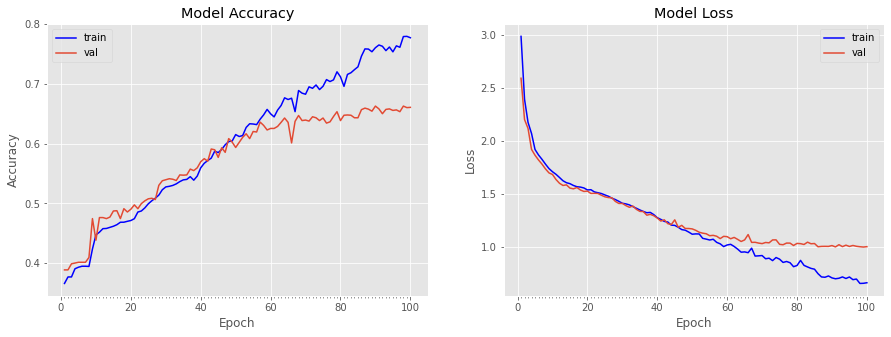

In [47]:
plot_curve(history)

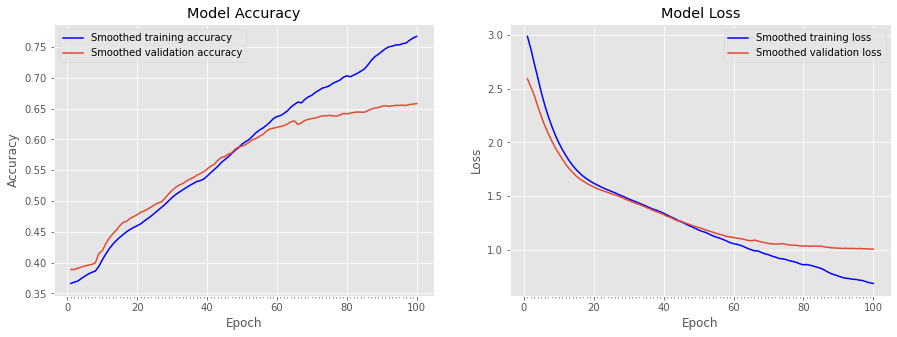

In [48]:
plot_curve_with_smooth(history)

## confusion_metrix

In [20]:
model.load_weights('./models/pinyin_gabor_cnn.h5')

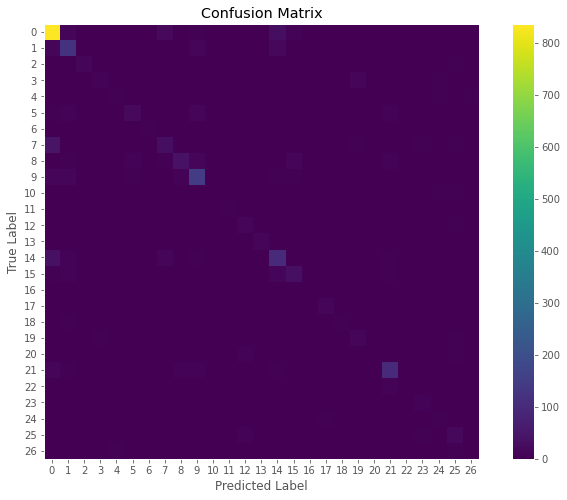

In [49]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
y_pred=model.predict(X_test)
y_pred=np.argmax(y_pred,axis=-1).ravel()
y_true=np.argmax(y_test,axis=-1).ravel()
con_matrix=confusion_matrix(y_true=y_true,y_pred=y_pred)
def plot_confusion_matrix(confusion_mat):
    plt.figure(figsize=(12,8))
    plt.imshow(confusion_mat)
    plt.title('Confusion Matrix')
    plt.colorbar()
    labels = list(range(0,27))
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.grid(False)
    plt.show() 
plot_confusion_matrix(con_matrix)

## classfication_report

In [50]:
from sklearn.metrics import classification_report


In [51]:
target_names=[alphabet_set[i] for i in range(27)]
print(classification_report(y_true,y_pred,digits=4,labels=list(range(27)),target_names=target_names))

              precision    recall  f1-score   support

           0     0.8665    0.9138    0.8895       916
           a     0.6596    0.7086    0.6832       175
           b     0.5652    0.4483    0.5000        29
           c     0.2800    0.2000    0.2333        35
           d     0.2500    0.2000    0.2222        25
           e     0.5000    0.3333    0.4000        63
           f     0.3333    0.3636    0.3478        11
           g     0.3896    0.3061    0.3429        98
           h     0.4762    0.3960    0.4324       101
           i     0.7277    0.7500    0.7387       196
           j     0.2000    0.1250    0.1538        16
           k     0.5556    0.4167    0.4762        12
           l     0.2174    0.3704    0.2740        27
           m     0.4000    0.4545    0.4255        22
           n     0.5611    0.5459    0.5534       185
           o     0.5000    0.5000    0.5000        70
           p     0.0000    0.0000    0.0000        10
           q     0.3750    

# predict test

In [81]:

temp = np.load('./gabor/person1_time1_group1_he_2.npy')
m,n = temp.shape
            #print(m)
if m <=35:
    left = 36 - m
    temp =np.append(temp,(np.zeros([left,n])),axis=0)
test =[]
test.append(temp[:35,])
test = np.array(test)
print(test.shape)
pred=model.predict(test)

pred=np.argmax(pred,axis=-1)[0]
text=[alphabet_set[i] for i in pred]
text=[i for i in text if i!='0']
text=''.join(text)
print('Predict Label:%s'%(text))

(1, 35, 7)
Predict Label:ji


In [82]:

temp = np.load('./gabor/person1_time1_group1_ba_1.npy')
m,n = temp.shape
            #print(m)
if m <=35:
    left = 36 - m
    temp =np.append(temp,(np.zeros([left,n])),axis=0)
test =[]
test.append(temp[:35,])
test = np.array(test)
print(test.shape)
pred=model.predict(test)

pred=np.argmax(pred,axis=-1)[0]
text=[alphabet_set[i] for i in pred]
text=[i for i in text if i!='0']
text=''.join(text)
print('Predict Label:%s'%(text))

(1, 35, 7)
Predict Label:maa


In [86]:

temp = np.load('./gabor/person2_time1_group1_da_4.npy')
m,n = temp.shape
            #print(m)
if m <=35:
    left = 36 - m
    temp =np.append(temp,(np.zeros([left,n])),axis=0)
test =[]
test.append(temp[:35,])
test = np.array(test)
print(test.shape)
pred=model.predict(test)

pred=np.argmax(pred,axis=-1)[0]
text=[alphabet_set[i] for i in pred]
text=[i for i in text if i!='0']
text=''.join(text)
print('Predict Label:%s'%(text))

(1, 35, 7)
Predict Label:maa
